# ***DBSCAN clustering***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.datasets import make_moons
from utils.plots_clustering import *

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos-Estadisticos/main/data/"

## ***Clustering y Limitaciones de K-means y Agglomerative***

El clustering es una técnica utilizada para agrupar datos similares. Los algoritmos ***K-means*** y ***Agglomerative Clustering*** son populares, pero tienen limitaciones con datos de formas no lineales.

- ***KMeans:***
Agrupa puntos en función de su distancia a un centroide buscando formar clusters esféricos. En datos con formas complejas K-means tiende a fallar porque intenta forzar grupos esféricos.

- ***Agglomerative Clustering:***
Agrupa jerárquicamente los puntos según su cercanía. Aunque más flexible que K-means, también tiene problemas con clusters no convexos o formas irregulares.

In [2]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
df_moons = pd.DataFrame(X, columns = ["feature_1","feature_2"])
display(df_moons.head())
px.scatter(df_moons, x="feature_1", y="feature_2", title="Make moons - Dataset")

,feature_1,feature_2
0,2.021001,0.490179
1,1.678201,-0.201987
2,-0.282245,0.858785
3,-0.021440,0.176281
4,0.504842,-0.391043


### ***K-means***

In [3]:
df_kmeans = df_moons.copy()
scaler = StandardScaler()
scaler_moons = scaler.fit_transform(df_kmeans)
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaler_moons)
df_kmeans["cluster_kmeans"] = kmeans.labels_
df_kmeans["cluster_kmeans"] = df_kmeans["cluster_kmeans"].astype("string")
px.scatter(df_kmeans, x="feature_1", y="feature_2", color="cluster_kmeans", title="Clustering with k-means")

### ***AgglomerativeClustering***

In [4]:
df_aglome = df_moons.copy()
aglome = AgglomerativeClustering(n_clusters=2)
aglome.fit(scaler_moons)
df_aglome["cluster_aglome"] = aglome.labels_
df_aglome["cluster_aglome"] = df_aglome["cluster_aglome"].astype("string")
px.scatter(df_aglome, x="feature_1", y="feature_2", color="cluster_aglome", title="Clustering with Agglomerative")

### ***DBSCAN***

In [5]:
# Con DBSCAN
df_dbscan = df_moons.copy()
dbscan = DBSCAN(eps=0.2, min_samples=4)
dbscan.fit(df_dbscan)
df_dbscan["cluster_DBSCAN"] = dbscan.labels_
df_dbscan["cluster_DBSCAN"] = df_dbscan["cluster_DBSCAN"].astype("string")

px.scatter(df_dbscan, x="feature_1", y="feature_2", color="cluster_DBSCAN", title="Clustering with DBSCAN").show()

# ***Note el único método que segmentó de manera adecuada fue DBSCAN.***

# Cuando se aplican algoritmos de clustering, por lo general no existe una "verdad" básica con la cual comparar los resultados.
# Hay métricas de puntuación para el clustering como el coeficiente de silueta. Este coeficiente calcula la compacidad de un clúster, 
# donde un valor más alto es mejor, con una puntuación perfecta de 1. Si bien los clústeres compactos son buenos, la compacidad no 
# trabaja bien en formas complejas formas.

algoritms = [kmeans, aglome, dbscan]

for algoritm in algoritms:
    clusters = algoritm.fit_predict(scaler_moons)
    score = silhouette_score(scaler_moons, clusters)
    print(f"Algoritmo: {algoritm} ---> silhouette_score: {score: .3f}")

Algoritmo: KMeans(n_clusters=2) ---> silhouette_score:  0.499
Algoritmo: AgglomerativeClustering() ---> silhouette_score:  0.457
Algoritmo: DBSCAN(eps=0.2, min_samples=4) ---> silhouette_score:  0.392


$K$-means obtiene la puntuación de silueta más alta, aunque se prefiere el resultado obtenido por DBSCAN.

## ***DBSCAN (Density-based spatial clustering of applications with noise)***

DBSCAN ("clustering con ruido basado en la densidad") es un algoritmo de clustering que busca la identificación de regiones "pobladas", es decir donde muchos registros están muy juntos, estas regiones se conocen como  ***regiones densas en el espacio de datos.***

La idea básica detrás de este enfoque de clustering se deriva de un método humano de agrupamiento intuitivo. Es decir, el cerebro humano puede identificar clusters observando los puntos que están cerca y además dejando sin ninguna asignación a registros que están aíslados (ruído). Así, ***los clusters son regiones densas en el espacio de datos, separadas por regiones de menor densidad de
puntos***. El algoritmo DBSCAN se basa en esta noción intuitiva de "clusters" y "ruido". La idea clave es que para cada punto de un cluster, la vecindad tiene que contener al menos un número mínimo de puntos.

Los principales beneficios de _DBSCAN_ son que no requiere que el usuario establezca el número de clusters a priori, puede capturar clusters de formas complejas y puede identificar puntos que no forman parte de ningún cluster. El algoritmo DBSCAN es algo más lento que el clustering aglomerativo y que $K$-means. Este algoritmo puede utilizarse para identificar clusters de cualquier forma en un Dataset que contenga ruido y valores atípicos.

## ***Ideas del método.***

La idea detrás de DBSCAN es que ***los clusters forman  regiones  densas de datos***, separadas por regiones que están relativamente vacías. Los puntos que están dentro de una región densa se denominan _core points_ (core points). Hay dos parámetros en DBSCAN: `min_samples` y `eps`. Si hay al menos `min_samples` puntos dentro de una distancia `eps` ($ϵ$-vecindad), ese punto se clasifica como un _core point_.  _Core points_ que están más cerca
entre sí que la distancia `eps` el algoritmo DBSCAN los coloca en el mismo cluster.

El algoritmo funciona eligiendo un punto arbitrario para comenzar. Luego encuentra ***todos los puntos con distancia menor o igual a la dada en `eps` (definición de $ϵ$-vecindad)***. Si hay menos de `min_samples` puntos dentro de la distancia `eps` del punto de partida, ***este punto se etiqueta como ruido,  lo que significa que no pertenece a ningún cluster (por ahora)***. Si hay más de `min_samples` puntos dentro de una distancia `eps`, el punto se etiqueta como _core point_ y se le asigna una nueva etiqueta de cluster. Luego, se visitan todos los vecinos ("viaja" por la $ϵ$-vecindad)  del punto, a estos puntos se les asigna la nueva etiqueta de cluster que se acaba de crear. Si
son _core points_, sus vecinos son visitados a su vez, y así sucesivamente. El cluster crece hasta que no hay más _core points_ a una distancia `eps` del cluster. Después
se elige otro punto que aún no ha sido visitado, y se sigue el mismo procedimiento anterior.



<center>

***ALGORITMO DBSCAN***

<img src="https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif" alt="drawing" width="600" height = "300"/>

</center>



## ***Algoritmo DBSCAN***

Vamos a definir tres conceptos:

- ***Core point:*** Una observación que tiene en su $ϵ$-vecindad un número de observaciones vecinas igual o mayor que `min_sample`.

- ***Boder point:*** Una observación que no satisface el número mínimo de observaciones vecinas para ser _core point_, pero pertenece a la $ϵ$-vecindad de otra observación que si es _core point_.

- ***Noise u outlier:*** Una observación que no es _core point_ ni _border point_.

Basados en las tres categorías anteriores se pueden definir tres niveles de conectividad entre observaciones:

- ***Directamente alcanzable (direct density reachable):*** Una observación $B$ es directamente alcanzable desde otra observación $A$ si $B$ forma parte de la $ϵ$-vecindad de $A$ y $A$ es un _core point_. Por definición, las observaciones solo pueden ser directamente alcanzables desde un _core point_.

- ***Alcanzable (density reachable):*** Una observación $A$ es alcanzable desde otra observación $B$ si existe una secuencia de _core points_ que van desde $B$ a $A$.

- ***Densamente conectadas (density conected):*** Dos observaciones $B$ y $C$ están densamente conectadas si existe una observación $A$ que es un _core point_, tal que $B$ y $C$ son alcanzables desde $A$.

<center>

<img src="https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/images/DBSCAN-Illustration.svg" alt="drawing" width="400" height = "200"/>

***Tomado de [wikipedía](https://es.wikipedia.org/wiki/DBSCAN)***

</center>



***La imagen anterior muestra las conexiones existentes entre un conjunto de observaciones con `min_samples=4`. La observación $A$ y el resto de observaciones marcadas con rojo son core points, ya que todas ellas contienen al menos 4 observaciones vecinas (incluyéndose a ellas mismas) en su $\epsilon$-vecindad. Como todas son alcanzables entre ellas, forman un cluster. Las observaciones $B$ y $C$ no son core points, pero son densamente alcanzables desde $A$ y densamente conectados con A, y por lo tanto pertenecen al mismo clúster. La observación $N$ no es ni _core point_ ni es directamente alcanzable, por lo tanto se considera como noise (ruido)***

### ***Algoritmo.***

1. Para cada observación $x_i$ calcular la distancia entre ella y el resto de observaciones. Si en su $ϵ$-vecindad hay un número de observaciones ***mayor o igual*** a `min_sample` marcar la observación como _core point_, de lo contrario marcarla como visitada.

2. Para cada observación $x_i$ marcada como _core point_, si todavía no ha sido asignada a ningún cluster, crear uno nuevo y asignarla a él. Encontrar recursivamente ***todas las observaciones densamente conectadas a ella*** y asignarlas al mismo cluster.

3. Iterar el mismo proceso para todas las observaciones que no hayan sido visitadas.

4. Aquellas observaciones que tras haber sido visitadas no pertenecen a ningún cluster se marcan como outliers.



***NOTA:*** Como resultado, todo cluster cumple dos propiedades: 

1. Todos los puntos que forman parte de un mismo cluster están ***densamente conectados entre ellos.***

2. Si una observación $A$ es ***densamente alcanzable desde cualquier otra observación*** de un cluster, entonces $A$ también pertenece al cluster.

## ***Selección de parámetros.***

Como ocurre en muchas otras técnicas estadísticas, en DBSCAN no existe una forma única y exacta de encontrar el valor adecuado de epsilon (`eps`) y `min_samples`. A modo orientativo se pueden seguir las siguientes premisas:

- `min_samples`: Cuanto mayor sea el tamaño del Dataset, mayor debe ser el valor mínimo de observaciones vecinas. En el libro de la referencia 1, recomiendan no bajar nunca de 3. Si los datos contienen niveles altos de ruido, aumentar `min_samples` favorecerá la creación de clusters significativos menos influenciados por outliers.

- `eps`: Una buena forma de escoger este valor consiste en calcular las distancias al $k$-ésimo vecino más cercano (donde $k$ corresponde a `min_samples`). Luego, estas k-ésimas distancias se trazan en orden ascendente. El objetivo es determinar la "rodilla", que corresponde al parámetro eps óptimo. Una rodilla corresponde a un umbral donde se produce un cambio brusco a lo largo de la curva de las k-ésimas distancias. Si el valor de eps escogido es muy pequeño, una proporción alta de las observaciones no se asignarán a ningún clúster, mientras que si el valor es demasiado grande, la mayoría de las observaciones se agruparán en un único clúster.

- `Distancia k de la curva`: Estudiar las distancias promedio entre las $k$ (`min_samples`) observaciones más próximas. Al representar estas distancias en función de `eps`, el punto de inflexión de la curva suele ser un valor óptimo. Si el valor de `eps` escogido es muy pequeño, una proporción alta de las observaciones no se asignarán a ningún cluster, por el contrario, si el valor es demasiado grande, la mayoría de observaciones se agruparán en un único cluster.

### ***Ventajas de DBSCAN.***

- A diferencia de $K$-means, DBSCAN no requiere que el usuario especifique el número de clusters a generar.

- DBSCAN es independiente de la forma que tengan los clusters, no tienen por qué ser circulares o convexos.

- DBSCAN puede identificar outliers, por lo que los clusters generados no son influenciados por ellos.

### ***Desventajas de DBSCAN.***

- No es un método totalmente determinístico: los border points que son alcanzables desde más de un cluster pueden asignarse a uno u otro dependiendo del orden en el que se procesen los datos.

- No genera buenos resultados cuando la densidad de los grupos es muy distinta, ya que no es posible encontrar los parámetros `eps` y `min_samples` que sirvan para todos a la vez.

## ***Ejemplo 1.***

Vamos a hacer uso de [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) para trabajar con el algoritmo.

In [6]:
df_usarrests = pd.read_csv(url_base + "USArrests.csv", index_col=0)
df_usarrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [7]:
# Escalamos la información.
scaler = StandardScaler()
#
df_scaler = pd.DataFrame(scaler.fit_transform(df_usarrests), columns=df_usarrests.columns, index=df_usarrests.index)
df_scaler.head(6)

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814
Colorado,0.025976,0.402909,0.869548,1.883901


In [8]:
knn_plot_dbscan(df_scaler, min_samples=2)

In [9]:
# Creamos una instancia de DBSCAN
clustering = DBSCAN(eps=1.349, min_samples=8)
clustering.fit(df_scaler)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 5,  8, 32,  5]))

In [10]:
# Ajustamos un PCA
pca = PCA(n_components=0.90)
pca.fit(df_scaler)
pca_array = pca.transform(df_scaler)

In [11]:
# Plot con 2 clusters.
cluster_biplot(pca, df_usarrests, clustering.labels_, size_text=5)

In [12]:
# Comparando clusters.
df_cluster = df_usarrests.copy()
df_cluster["cluster"] = clustering.labels_
df_cluster.head()

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,-1
Arizona,8.1,294,80,31.0,2
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,-1


In [13]:
df_cluster_plot = df_cluster.query("cluster !=-1")
df_cluster_plot["cluster"] = df_cluster_plot["cluster"].astype("category")

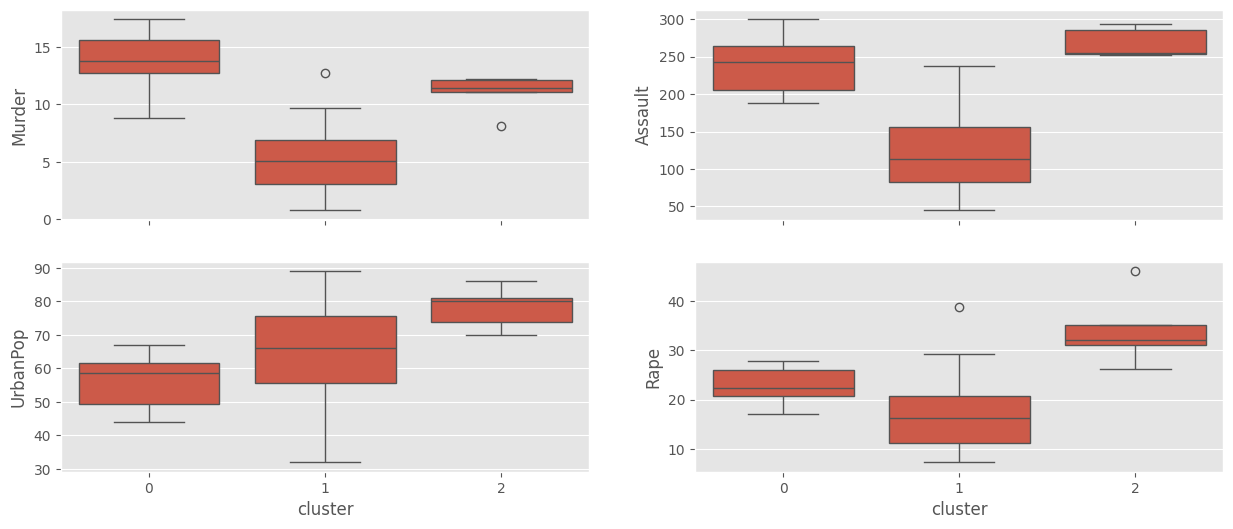

In [14]:
# Box-plots
fig, axes = plt.subplots(2,2, sharex=True)
#
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Murder", ax = axes[0,0])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Assault", ax = axes[0,1])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "UrbanPop", ax = axes[1,0])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Rape", ax = axes[1,1])
plt.show()

### ***OTRO ESCALADOR.***

In [15]:
# Escalamos la información.
scaler_min_max = MinMaxScaler()
min_max_transform = scaler_min_max.fit_transform(df_usarrests)
##
df1 = pd.DataFrame(min_max_transform, columns=df_usarrests.columns, index = df_usarrests.index)
df1.head(6)

,Murder,Assault,UrbanPop,Rape
Alabama,0.746988,0.654110,0.440678,0.359173
Alaska,0.554217,0.746575,0.271186,0.961240
Arizona,0.439759,0.852740,0.813559,0.612403
Arkansas,0.481928,0.496575,0.305085,0.315245
California,0.493976,0.791096,1.000000,0.860465
Colorado,0.427711,0.544521,0.779661,0.811370


In [16]:
knn_plot_dbscan(df1, min_samples=2)

In [17]:
clustering = DBSCAN(eps=0.35, min_samples=8)
clustering.fit(df1)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 4,  8, 32,  6]))

In [18]:
clustering.labels_

array([ 0, -1,  2,  0, -1,  1,  1,  1, -1,  0,  1,  1,  2,  1,  1,  1,  1,
        0,  1,  0,  1,  2,  1,  0,  1,  1,  1,  2,  1,  1,  2,  2, -1,  1,
        1,  1,  1,  1,  1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1])

In [19]:
pca = PCA(n_components=0.90)
pca_transform_min_max = pca.fit_transform(df1)
pd.DataFrame(pca_transform_min_max).head()

,0,1,2
0,0.293082,-0.273177,-0.098603
1,0.497299,-0.225498,0.501542
2,0.460302,0.201380,0.003031
3,-0.006003,-0.275698,0.028729
4,0.612016,0.409985,0.143261


In [20]:
knn_plot_dbscan(pca_transform_min_max, min_samples=2)

In [21]:
clustering = DBSCAN(eps=0.258, min_samples=6)
clustering.fit(pca_transform_min_max)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 8,  6, 30,  6]))

## ***Ejemplo 2.***

Vamos a considerar la siguiente data de clientes, la idea será realizar una segmentación de esta información

In [22]:
# Clientes 
path = "clientes_clustering.csv"
clientes = pd.read_csv(url_base + path, index_col=0)
clientes

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [23]:
px.scatter(clientes, x="Annual Income (k$)", y="Spending Score (1-100)", color="Genre").show()
px.scatter(clientes, x="Age", y="Spending Score (1-100)", color="Genre").show()

In [24]:
df2 = clientes.copy()
df2 = df2.iloc[:,1:]
df2.head()

,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


In [25]:
scaler = StandardScaler()

df2_dbscan = pd.DataFrame(scaler.fit_transform(clientes.select_dtypes(np.number)), columns=df2.columns)
df2_dbscan

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [26]:
knn_plot_dbscan(df2_dbscan, min_samples=2)

In [27]:
clustering2 = DBSCAN(eps=0.606, min_samples=6)
clustering2.fit(df2_dbscan)
np.unique(clustering2.labels_, return_counts=True)


(array([-1,  0,  1,  2,  3,  4]), array([ 33, 106,   5,   4,  34,  18]))

In [28]:
pca = PCA(n_components=0.9)
pca.fit(df2_dbscan)
cluster_biplot(pca, clientes.drop(columns=["Genre"]), clustering2.labels_, size_text=5)

## ***Referencias:***

1. _Multivariate Analysis I. Kassambara A. Disponible en: http://www.sthda.com/english/_

3. [_Selecting the number of clusters with silhouette analysis on KMeans clustering_](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) [_by sklearn_](https://scikit-learn.org/stable/)